# Whole-Body Detection & Pose Estimation (First 5 Frames)

This notebook uses the `rtmlib` library (Wholebody solution) to perform full-body person detection and pose estimation (133 keypoints) on the first 5 frames of the sample video in `data/test.mov`.

Steps:
1. Install dependencies (rtmlib + backends)
2. Initialize Wholebody model (auto-download ONNX models)
3. Read first 5 frames from the video
4. Run inference per frame
5. Draw skeletons and bounding boxes
6. Display the annotated frames inline

If you prefer performance vs. accuracy, adjust the `mode` parameter: `performance | lightweight | balanced`.


In [1]:
# Install rtmlib (lightweight pose estimation library)
# NOTE: If already installed, you can skip this cell.
import sys, subprocess, pkgutil
packages = ['rtmlib']
for p in packages:
    if pkgutil.find_loader(p) is None:
        print(f'Installing {p}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', p])
    else:
        print(f'{p} already installed')

# Optional: onnxruntime-gpu (only if you have GPU & want speed). Commented out by default.
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'onnxruntime-gpu'])

rtmlib already installed


In [2]:
import cv2, numpy as np, os, math
from pathlib import Path
from typing import List, Tuple

from rtmlib import Wholebody, draw_skeleton, draw_bbox

# Configuration
VIDEO_PATH = Path('../data/test.mov').resolve()
DEVICE = 'cpu'  # 'cuda', 'mps', or 'cpu'
BACKEND = 'onnxruntime'  # 'onnxruntime', 'opencv', 'openvino'
MODE = 'balanced'  # 'performance', 'lightweight', 'balanced'
NUM_FRAMES = 5
KPT_THRESHOLD = 0.3

assert VIDEO_PATH.exists(), f'Video not found: {VIDEO_PATH}'

wholebody = Wholebody(mode=MODE, backend=BACKEND, device=DEVICE, to_openpose=False)
print('Wholebody model initialized.')

cap = cv2.VideoCapture(str(VIDEO_PATH))
frames = []

for i in range(NUM_FRAMES):
    ret, frame = cap.read()
    if not ret:
        print('End of video or cannot read more frames.')
        break
    frames.append(frame)

cap.release()
print(f'Collected {len(frames)} frames.')

results = []  # List of (annotated_bgr, keypoints, scores, bboxes)
for idx, frame in enumerate(frames):
    # 1. Run detector to get person bboxes (x1,y1,x2,y2,score)
    bboxes = wholebody.det_model(frame)  # ndarray (N,5) or empty
    # 2. Run pose model with those bboxes
    keypoints, scores = wholebody.pose_model(frame, bboxes=bboxes)

    canvas = frame.copy()
    if len(bboxes) > 0:
        canvas = draw_bbox(canvas, bboxes)
        canvas = draw_skeleton(canvas, keypoints, scores, kpt_thr=KPT_THRESHOLD)
    else:
        print(f'Frame {idx}: no persons detected')

    num_persons = 0 if keypoints is None else (0 if len(keypoints)==0 else keypoints.shape[0])
    print(f'Frame {idx}: persons={num_persons}')
    results.append((canvas, keypoints, scores, bboxes))

print('Inference done.')

load /Users/benjaminbruch/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
load /Users/benjaminbruch/.cache/rtmlib/hub/checkpoints/rtmw-dw-x-l_simcc-cocktail14_270e-256x192_20231122.onnx with onnxruntime backend
Wholebody model initialized.
Collected 5 frames.


2025-08-15 10:31:20.630273 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1709'. It is not used by any node and should be removed from the model.
2025-08-15 10:31:20.630316 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1701'. It is not used by any node and should be removed from the model.
2025-08-15 10:31:20.630332 [W:onnxruntime:, graph.cc:4454 CleanUnusedInitializersAndNodeArgs] Removing initializer '1706'. It is not used by any node and should be removed from the model.


Frame 0: persons=1
Frame 1: persons=1
Frame 2: persons=1
Frame 3: persons=1
Frame 4: persons=1
Inference done.


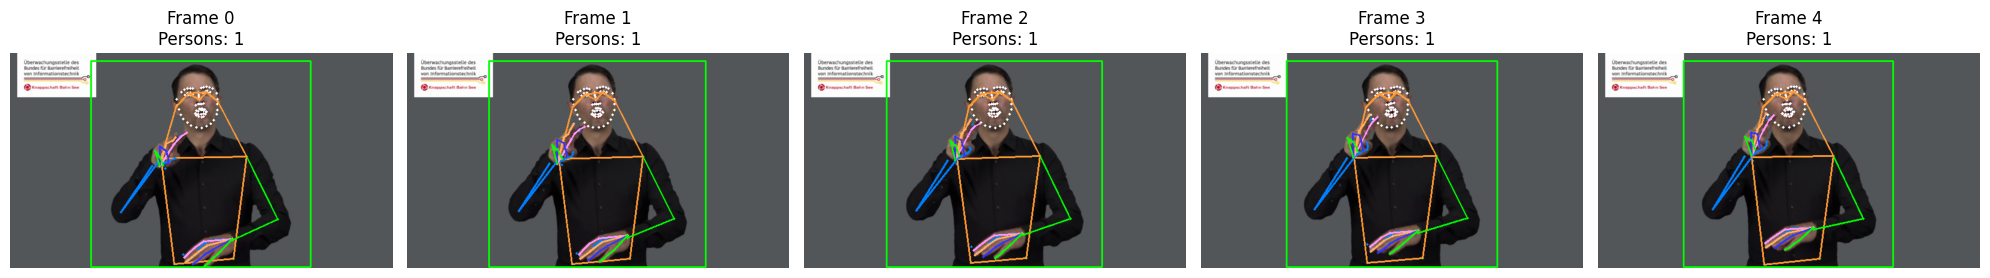

In [3]:
import matplotlib.pyplot as plt

cols = NUM_FRAMES
plt.figure(figsize=(4*cols, 4))
for i, (canvas, kpts_list, scores_list, bboxes) in enumerate(results):
    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(1, cols, i+1)
    ax.imshow(rgb)
    ax.set_title(f'Frame {i}\nPersons: {len(kpts_list)}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Optional: Save annotated frames
save_dir = Path('../output/02_pose_estimation')
save_dir.mkdir(parents=True, exist_ok=True)
for i, (canvas, _, _, _) in enumerate(results):
    out_path = save_dir / f'frame_{i:02d}.jpg'
    cv2.imwrite(str(out_path), canvas)
print(f'Saved {len(results)} frames to {save_dir}')

Saved 5 frames to ../output/02_pose_estimation
